# Deep Gaussian processes with Latent Variables

In this notebook, we explore the use of Deep Gaussian processes <cite data-cite="damianou2013deep"/> and Latent Variables to model a dataset with heteroscedastic noise. The model can be seen as a deep GP version of <cite data-cite="dutordoir2018cde"/> or as doing variational inference in models from <cite data-cite="salimbeni2019iwvi"/>. We start by fitting a single layer GP model to show that it doesn't result in a satisfactory fit for the noise.

This notebook is inspired by [prof. Neil Lawrence's Deep Gaussian process talk](https://inverseprobability.com/talks/notes/deep-gps.html), which we highly recommend watching.

In [1]:
import tensorflow as tf
import gpflow
import gpflux
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_probability as tfp
from sklearn.neighbors import KernelDensity


## Load data

The data comes from a motorcycle accident simulation [1] and shows some interesting behaviour. In particular the heteroscedastic nature of the noise.

In [2]:
def motorcycle_data():
    """ Return inputs and outputs for the motorcycle dataset. We normalise the outputs. """
    import pandas as pd
    df = pd.read_csv("./data/motor.csv", index_col=0)
    X, Y = df["times"].values.reshape(-1, 1), df["accel"].values.reshape(-1, 1)
    Y = (Y - Y.mean()) / Y.std()
    X /= X.max()
    return X, Y

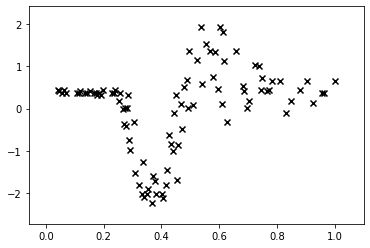

In [3]:
X, Y = motorcycle_data()
num_data, d_xim = X.shape

X_MARGIN, Y_MARGIN = 0.1, 0.5
fig, ax = plt.subplots()
ax.scatter(X, Y, marker='x', color='k');
ax.set_ylim(Y.min() - Y_MARGIN, Y.max() + Y_MARGIN);
ax.set_xlim(X.min() - X_MARGIN, X.max() + X_MARGIN);

## Standard single layer Sparse Variational GP

We first show that a single layer SVGP performs quite poorly on this dataset. In the following code block we define the kernel, inducing variable, GP layer and likelihood of the shallow GP:

In [4]:
NUM_INDUCING = 20

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(X.min(), X.max(), NUM_INDUCING).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=1
)
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))



We can now encapsulate `gp_layer` in a GPflux DeepGP model:

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Text(0, 0.5, 'Loss')

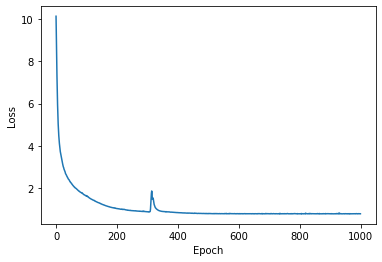

In [5]:

single_layer_dgp = gpflux.models.DeepGP([gp_layer], likelihood_layer)
model = single_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

history = model.fit({"inputs": X, "targets": Y}, epochs=int(1e3), verbose=0)
fig, ax = plt.subplots()
ax.plot(history.history["loss"])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

Text(0, 0.5, 'acc')

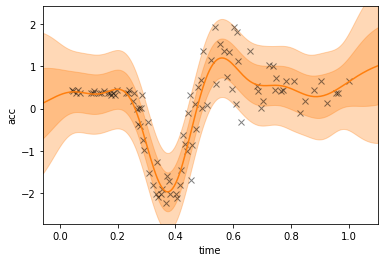

In [6]:
fig, ax = plt.subplots()
num_data_test = 200
X_test = np.linspace(X.min() - X_MARGIN, X.max() + X_MARGIN, num_data_test).reshape(-1, 1)
model = single_layer_dgp.as_prediction_model()
out = model(X_test)

mu = out.y_mean.numpy().squeeze()
var = out.y_var.numpy().squeeze()
X_test = X_test.squeeze()

for i in [1, 2]:
    lower = mu - i * np.sqrt(var)
    upper = mu + i * np.sqrt(var)
    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)

ax.set_ylim(Y.min() - Y_MARGIN, Y.max() + Y_MARGIN)
ax.set_xlim(X.min() - X_MARGIN, X.max() + X_MARGIN)
ax.plot(X, Y, "kx", alpha=0.5)
ax.plot(X_test, mu, "C1")
ax.set_xlabel('time')
ax.set_ylabel('acc')


The errorbars of the single layer model are not good: we observe an overestimation of the error bars on the left and right. 

## Deep Gaussian process with latent variables

To tackle the problem we suggest a Deep Gaussian process with a latent variable in the first layer. The latent variable will be able to capture the 
heteroscedasticity, while the two-layered deep GP is able to model the sharp transitions. 

Note that a GPflux Deep Gaussian process by itself (i.e. without the latent variable layer) is not able to capture the heteroscedasticity of this dataset. This is a consequence of the noise-less hidden layers and the doubly-stochastic variational inference training procedure, as forumated in <cite data-cite="salimbeni2017doubly">. On the contrary, the original deep GP suggested by Damianou and Lawrence <cite data-cite="damianou2013deep">, using a different variational approximation for training, can model this dataset without a latent variable, as shown in [this blogpost](https://inverseprobability.com/talks/notes/deep-gps.html). 

### Latent Variable Layer

This layer concatenates the inputs with a latent variable. See Dutordoir, Salimbeni et al. Conditional Density with Gaussian processes (2018) <cite data-cite="dutordoir2018cde"/> for full details. We choose a one-dimensional input and a full parameterisation for the latent variables. This means that we do not need to train a recognition network, which is useful for fitting but can only be done in the case of small datasets, as is the case here.

In [7]:
w_dim = 1
prior_means = np.zeros(w_dim)
prior_std = np.ones(w_dim)
encoder = gpflux.encoders.DirectlyParameterizedNormalDiag(num_data, w_dim)
prior = tfp.distributions.MultivariateNormalDiag(prior_means, prior_std)
lv = gpflux.layers.LatentVariableLayer(prior, encoder)

### First GP layer

GP Layer with two dimensional input because it acts on the inputs and the one-dimensional latent variable. We use a Squared Exponential kernel, a zero mean function, and inducing points, whose pseudo input locations are carefully chosen.

In [8]:

kernel = gpflow.kernels.SquaredExponential(lengthscales=[.05, .2], variance=1.)
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.concatenate(
        [
            np.linspace(X.min(), X.max(), NUM_INDUCING).reshape(-1, 1),
            np.random.randn(NUM_INDUCING, 1),
        ],
        axis=1
    )
)
gp_layer = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Zero(),
)

### Second GP layer

Final layer GP with Squared Exponential kernel

In [9]:

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.random.randn(NUM_INDUCING, 1),
)
gp_layer2 = gpflux.layers.GPLayer(
    kernel,
    inducing_variable,
    num_data=num_data,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Identity(),
)
gp_layer2.q_sqrt.assign(gp_layer.q_sqrt * 1e-5);

In [10]:

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))
gpflow.set_trainable(likelihood_layer, False)
dgp = gpflux.models.DeepGP([lv, gp_layer, gp_layer2], likelihood_layer)
gpflow.utilities.print_summary(dgp, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._layers[0].means DeepGP.f_layers[0].encoder.means,Parameter,Identity,,True,"(94, 1)",float64,[[2.01673752e-02...
DeepGP.f_layers[0]._layers[0].stds DeepGP.f_layers[0].encoder.stds,Parameter,Softplus,,True,"(94, 1)",float64,[[1.e-05...
DeepGP.f_layers[1].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
DeepGP.f_layers[1].kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.05 0.2 ]
DeepGP.f_layers[1].inducing_variable.Z,Parameter,Identity,,True,"(20, 2)",float64,"[[0.04166667, 0.66191201..."
DeepGP.f_layers[1].q_mu,Parameter,Identity,,True,"(20, 1)",float64,[[0....
DeepGP.f_layers[1].q_sqrt,Parameter,FillTriangular,,True,"(1, 20, 20)",float64,"[[[1., 0., 0...."
DeepGP.f_layers[2].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
DeepGP.f_layers[2].kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
DeepGP.f_layers[2].inducing_variable.Z,Parameter,Identity,,True,"(20, 1)",float64,[[2.48779388...


### Fit

We can now fit the model. Because of the `DirectlyParameterizedEncoder` it is important to set the batch size to the number of datapoints and turn off shuffle. This is so that we use the associated latent variable for each datapoint. If we would use an amortized encoder network this would not be necessary.

In [17]:
model = dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.005))
history = model.fit({"inputs": X, "targets": Y}, epochs=int(20e3), verbose=0, batch_size=num_data, shuffle=False)

In [18]:
gpflow.utilities.print_summary(dgp, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[0]._metrics[0].total,ResourceVariable,,,False,(),float64,1.0780249257681602
DeepGP.f_layers[0]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[0]._metrics[0].count,ResourceVariable,,,False,(),float64,1.0
DeepGP.f_layers[0]._layers[0].means DeepGP.f_layers[0].encoder.means,Parameter,Identity,,True,"(94, 1)",float64,[[0.03641934...
DeepGP.f_layers[0]._layers[0].stds DeepGP.f_layers[0].encoder.stds,Parameter,Softplus,,True,"(94, 1)",float64,[[0.8204074...
DeepGP.f_layers[1]._metrics[0]._non_trainable_weights[0] DeepGP.f_layers[1]._metrics[0].total,ResourceVariable,,,False,(),float64,0.4804222860958632
DeepGP.f_layers[1]._metrics[0]._non_trainable_weights[1] DeepGP.f_layers[1]._metrics[0].count,ResourceVariable,,,False,(),float64,1.0
DeepGP.f_layers[1].kernel.variance,Parameter,Softplus,,True,(),float64,0.8957803239319818
DeepGP.f_layers[1].kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.13181667 4.24491404]
DeepGP.f_layers[1].inducing_variable.Z,Parameter,Identity,,True,"(20, 2)",float64,"[[0.10892382, -0.15883231..."
DeepGP.f_layers[1].q_mu,Parameter,Identity,,True,"(20, 1)",float64,[[3.44379760e-02...


### Prediction and plotting code

In [19]:
Xs = np.linspace(X.min() - X_MARGIN, X.max() + X_MARGIN, num_data_test).reshape(-1, 1)

def predict_y_samples(prediction_model, Xs, num_samples=25):
    samples = []
    for i in tqdm(range(num_samples)):
        out = prediction_model(Xs)
        s = out.y_mean + out.y_var ** .5 * tf.random.normal(tf.shape(out.y_mean), dtype=out.y_mean.dtype)
        samples.append(s)
    return tf.concat(samples, axis=1)


def plot_samples(ax, N_samples=25):
    samples = predict_y_samples(dgp.as_prediction_model(), Xs, N_samples).numpy().T
    Xs_tiled = np.tile(Xs, [N_samples, 1])
    ax.scatter(Xs_tiled.flatten(), samples.flatten(), marker='.', alpha=0.2, color='C0')
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlim(min(Xs), max(Xs))
    ax.scatter(X, Y, marker='.', color='C1')


def plot_latent_variables(ax):
    for l in dgp.f_layers:
        if isinstance(l, gpflux.layers.LatentVariableLayer):
            m = l.encoder.means.numpy()
            s = l.encoder.stds.numpy()
            ax.errorbar(X.flatten(), m.flatten(), yerr=s.flatten(), fmt='o')
            return


100%|██████████| 25/25 [00:01<00:00, 24.88it/s]


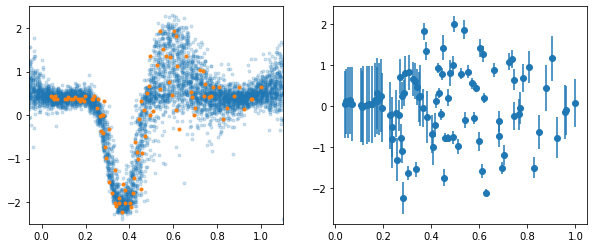

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_samples(ax1)
plot_latent_variables(ax2)

Left we show the dataset and posterior samples of $y$. On the right we plot the mean and std. deviation of the latent variables corresponding to the datapoints.

In [23]:
def plot_mean_and_var(ax, samples=None, N_samples=5_000):
    if samples is None:
        samples = predict_y_samples(dgp.as_prediction_model(), Xs, N_samples).numpy().T

    m = np.mean(samples, 0).flatten()
    v = np.var(samples, 0).flatten()

    ax.plot(Xs.flatten(), m, "C1")
    for i in [1, 2]:
        lower = m - i * np.sqrt(v)
        upper = m + i * np.sqrt(v)
        ax.fill_between(Xs.flatten(), lower, upper, color="C1", alpha=0.3)
    ax.plot(X, Y, "kx", alpha=0.5)
    ax.set_ylim(Y.min() - Y_MARGIN, Y.max() + Y_MARGIN)
    ax.set_xlabel("time")
    ax.set_ylabel("acceleration")
    return samples


100%|██████████| 5000/5000 [03:24<00:00, 24.44it/s]


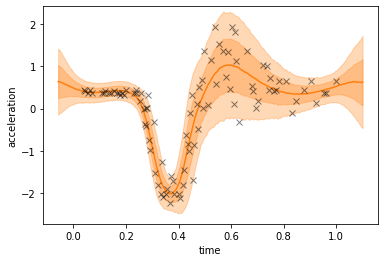

In [24]:
fig, ax = plt.subplots()
plot_mean_and_var(ax);

The deep GP model can handle the heteroscedastic noise in the dataset as well as the sharp-ish transition at $0.3$.

## Conclusion

In this notebook we created a two layer deep Gaussian process with a latent variable base layer to model a heteroscedastic dataset using GPflux.


[1] Silverman, B. W. (1985) “Some aspects of the spline smoothing approach to non-parametric curve fitting”. Journal of the Royal Statistical Society series B 47, 1-52.